In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(color_codes=True)
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#For lstm model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#for Arima model
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Datasets/Rainfall_1901_2016_PAK.csv")

In [ ]:
df.head()

,Rainfall - (MM),Year,Month
0,40.4258,1901,January
1,12.3022,1901,February
2,25.5119,1901,March
3,14.2942,1901,April
4,38.3046,1901,May


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rainfall - (MM)  1392 non-null   float64
 1    Year            1392 non-null   int64  
 2   Month            1392 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 32.8+ KB


In [ ]:
df['Date']=pd.to_datetime(df[' Year'].astype(str)  + df['Month'], format='%Y%B').dt.to_period('m')
df = df.set_index('Date')
df = df.rename(columns = {'Rainfall - (MM)':'Rainfall',' Year':'Year'})
df.head()

,Rainfall,Year,Month
Date,,,
1901-01,40.4258,1901,January
1901-02,12.3022,1901,February
1901-03,25.5119,1901,March
1901-04,14.2942,1901,April
1901-05,38.3046,1901,May


In [ ]:
!pip install python-dateutil
import pandas as pd
from datetime import datetime

df['Month'] = df['Month'].apply(lambda x: datetime.strptime(x, '%B').month)
df['Month'] = df['Month'].astype(float)

In [ ]:
df.head()

,Rainfall,Year,Month
Date,,,
1901-01,40.4258,1901,1.0
1901-02,12.3022,1901,2.0
1901-03,25.5119,1901,3.0
1901-04,14.2942,1901,4.0
1901-05,38.3046,1901,5.0


In [ ]:
pip install pandas plotly --upgrade

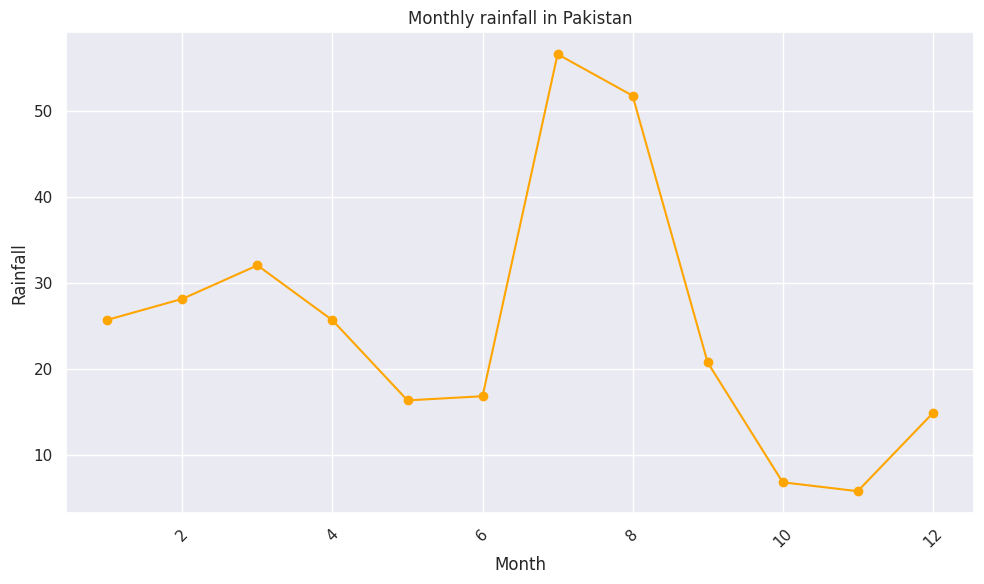

In [ ]:
import pandas as pd
import plotly.express as px

ax = df.groupby('Month', as_index=False).mean()

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(ax['Month'], ax['Rainfall'], marker='o', linestyle='-', color='orange')
plt.title('Monthly rainfall in Pakistan')
plt.xlabel('Month')
plt.ylabel('Rainfall')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

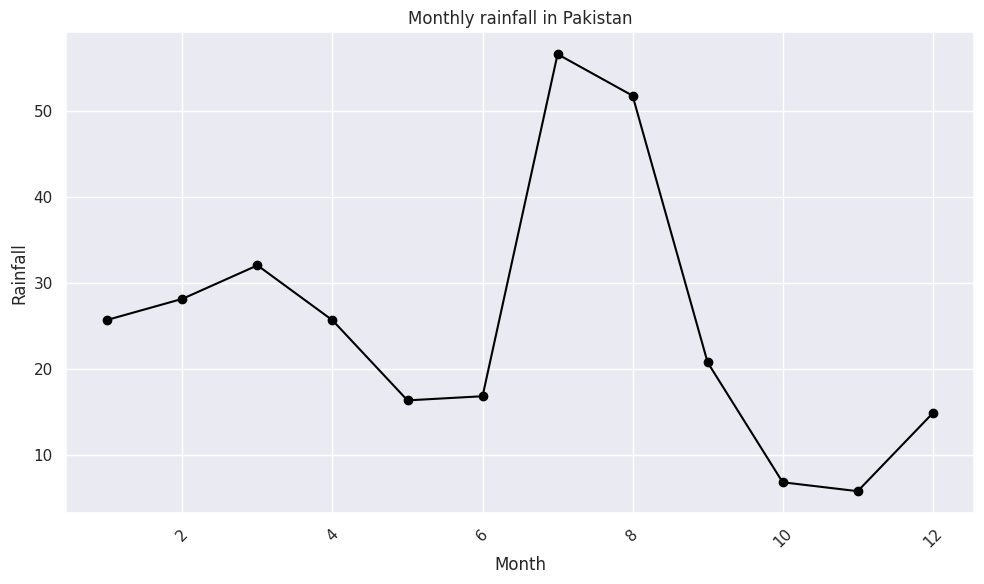

In [ ]:
ax = df.groupby('Month').mean()

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
# Use ax.index to access the 'Month' values, and ax['Rainfall'] to access rainfall data
plt.plot(ax.index, ax['Rainfall'], marker='o', linestyle='-', color='Black')
plt.title('Monthly rainfall in Pakistan')
plt.xlabel('Month')
plt.ylabel('Rainfall')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

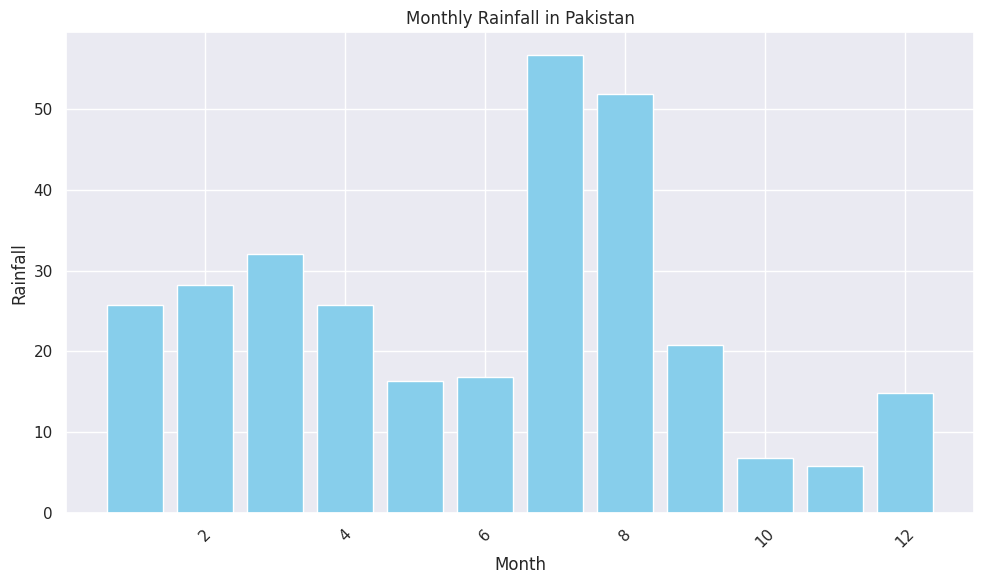

In [ ]:
ax = df.groupby('Month', as_index=False).mean()

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ax['Month'], ax['Rainfall'], color='skyblue')
plt.title('Monthly Rainfall in Pakistan')
plt.xlabel('Month')
plt.ylabel('Rainfall')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
ax=df.groupby([df.index.year]).agg({'Rainfall':sum})
print('The largest amount of rain was recorded in the following years')
ax['Rainfall'].nlargest(5)

The largest amount of rain was recorded in the following years


Date
1944    494.37035
1956    431.99396
1994    423.27579
1942    414.70332
1959    404.21003
Name: Rainfall, dtype: float64

In [ ]:
#Data preprcessing
dataset = df.drop(columns = ['Month','Year'])
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
df.head()

,Rainfall,Year,Month
Date,,,
1901-01,40.4258,1901,1.0
1901-02,12.3022,1901,2.0
1901-03,25.5119,1901,3.0
1901-04,14.2942,1901,4.0
1901-05,38.3046,1901,5.0


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# split into train and test sets
training_size=int(len(dataset)*0.90)
test_size=len(dataset)-training_size
train, test =dataset[0:training_size,:],dataset[training_size:len(dataset),:1]

#reshape into X=t and Y=t+1
look_back =12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,look_back)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=5, validation_data=(testX, testY), shuffle=False)

Epoch 1/10
248/248 [==============================] - 10s 18ms/step - loss: 0.0192 - val_loss: 0.0162
Epoch 2/10
248/248 [==============================] - 2s 8ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 3/10
248/248 [==============================] - 2s 8ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 4/10
248/248 [==============================] - 3s 11ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 5/10
248/248 [==============================] - 2s 7ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 6/10
248/248 [==============================] - 2s 7ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 7/10
248/248 [==============================] - 2s 10ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 8/10
248/248 [==============================] - 2s 10ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 9/10
248/248 [==============================] - 2s 7ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 10/10
248/248 [==============================] - 2s 7ms/step - loss: 0.0150 - val_loss: 0

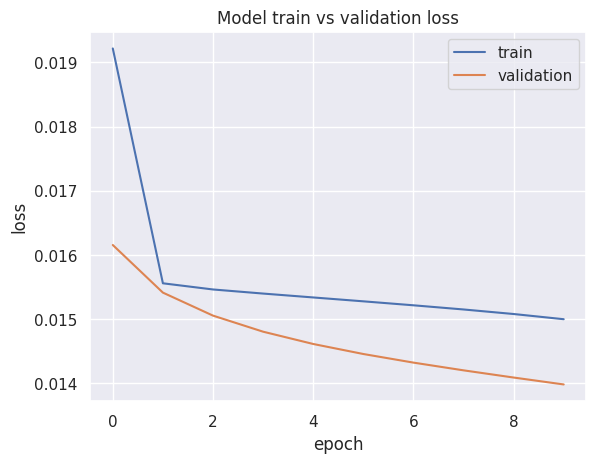

In [ ]:
# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

4/4 [==============================] - 0s 8ms/step
Test Score: 18.20 RMSE


4/4 [==============================] - 0s 7ms/step
Test Score: 18.20 RMSE


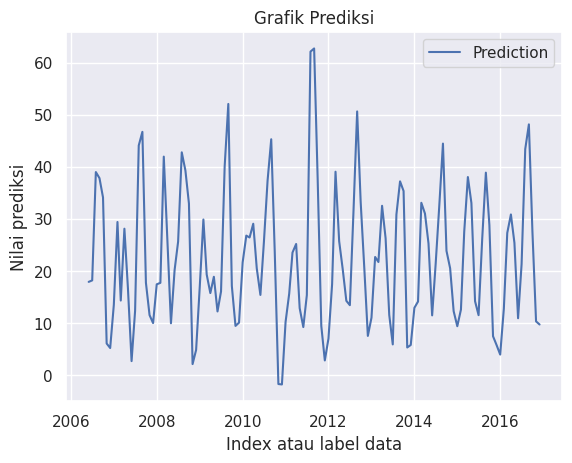

In [ ]:
testPredict = model.predict(testX)
# invert predictions
test_Predict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(test_Y[0], test_Predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Convert the PeriodIndex to a datetime index
df_Month.index = df_Month.index.to_timestamp()

# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(df_Month.index, df_Month['Prediction'], label='Prediction')
plt.xlabel('Index atau label data')
plt.ylabel('Nilai prediksi')
plt.title('Grafik Prediksi')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_result=adfuller(df['Rainfall'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Rainfall'])

ADF Test Statistic : -6.695889008362755
p-value : 4.000735413148449e-09
#Lags Used : 23
Number of Observations : 1368
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
# split into train and test sets
training_size=int(len(df)*0.90)
test_size=len(df)-training_size
train,valid=df.iloc[0:training_size,:],df.iloc[training_size:len(df),:1]
training = train['Rainfall']
validation = valid['Rainfall']

In [ ]:
model = auto_arima(training, start_p=0, start_q=0,max_p=3, max_q=3, m=12,start_P=0,start_Q=0,max_P=1,max_Q=1, seasonal=True,d=0, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11329.894, Time=0.30 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10964.788, Time=5.02 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11327.903, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11318.676, Time=0.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=10970.745, Time=2.13 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=10966.573, Time=5.09 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=10966.244, Time=6.50 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=10964.602, Time=2.49 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=11317.821, Time=0.47 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.37 sec
 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=10966.477, Time=4.10 sec
 ARIMA(1,0,2)(1,1,0)[12] inte

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
testScore = math.sqrt(mean_squared_error(valid,future_forecast))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 16.37 RMSE
